# LUAD CPTAC analysis

In [431]:
import pandas as pd
import numpy as np
from msresist.pre_processing import preprocessing
from msresist.clustering import MassSpecClustering
import matplotlib.pyplot as plt
sns.set(style="whitegrid", font_scale=1, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

In [5]:
# pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.max_rows', 1000000)
# pd.set_option('display.max_columns', 1000)

## 1 - Import and Preprocess Data

In [6]:
# X = preprocessing(CPTAC=True, log2T=True)
X = pd.read_csv("msresist/data/MS/CPTAC/CPTAC-preprocessedMotfis.csv")

d = X.select_dtypes(include=['float64']).T
i = X.select_dtypes(include=['object'])

In [470]:
print(X.shape)
X

Sequence         Protein       Gene Position  C3N.01799  \
0      AAAAAsGGGVS     NP_002577.2       PBX2   S146-p        NaN   
1      AAAAAsQQGSA  NP_001308122.1    TBL1XR1   S119-p        NaN   
2      AAAAAsTQAQQ  NP_001035540.1     MINDY2   S575-p   0.012034   
3      AAAAGsASPRS     NP_064520.2     WRNIP1   S151-p        NaN   
4      AAAAGsGPSPP     NP_060895.1     PI4K2A    S44-p        NaN   
...            ...             ...        ...      ...        ...   
42378  YYSTEsEPLTN     NP_055869.1  UHRF1BP1L   S777-p        NaN   
42379  YYTAGyNSPVK  NP_001313309.1      HEBP2   Y179-p        NaN   
42380  YYTIPsMDDLA     NP_057404.2      NUP98   S746-p        NaN   
42381  YYTSAsGDEMV  NP_001017963.2   HSP90AA1   S470-p        NaN   
42382  YYYSSsEDEDS     NP_005379.3       PDCL    S20-p  -1.383602   

       C3N.01799.N  C3L.01890  C3L.01890.N  C3N.00572  C3N.00572.N  C3N.02423  \
0              NaN        NaN          NaN        NaN          NaN        NaN   
1              NaN        NaN          NaN        NaN          NaN        NaN   
2        -0.630863  -1.159479    -0.740044   0.107228    -0.016971  -0.023379   
3              NaN        NaN          NaN        NaN          NaN        NaN   
4              NaN        NaN          NaN        NaN          NaN        NaN   
...            ...        ...          ...        ...          ...        ...   
42378          NaN        NaN          NaN        NaN          NaN        NaN   
42379          NaN        NaN          NaN        NaN          NaN        NaN   
42380          NaN        NaN          NaN        NaN          NaN        NaN   
42381          NaN        NaN          NaN        NaN          NaN        NaN   
42382    -3.411367   1.133625    -0.965494  -1.657002    -2.817511  -0.721298   

       C3N.02423.N  C3N.02729  C3N.02729.N  C3L.00263  ...  C3N.00738.N  \
0              NaN        NaN          NaN        NaN  ...          NaN   
1              NaN        NaN          NaN        NaN  ...    -0.600298   
2        -0.481045        NaN          NaN        NaN  ...          NaN   
3              NaN        NaN          NaN        NaN  ...          NaN   
4              NaN   0.837830    -0.993838   0.317079  ...    -0.554645   
...            ...        ...          ...        ...  ...          ...   
42378          NaN        NaN          NaN        NaN  ...          NaN   
42379          NaN        NaN          NaN        NaN  ...          NaN   
42380          NaN        NaN          NaN        NaN  ...          NaN   
42381          NaN        NaN          NaN        NaN  ...    -0.772532   
42382    -3.320824  -2.058383    -3.708667  -0.690239  ...    -2.695575   

       C3N.00959  C3N.00959.N  C3N.02003  C3N.02003.N  C3N.02379.N  C3N.00175  \
0            NaN          NaN        NaN          NaN          NaN        NaN   
1       0.172339    -1.761406   0.421872    -0.372907    -0.979491  -0.083036   
2            NaN          NaN        NaN          NaN          NaN        NaN   
3            NaN          NaN        NaN          NaN          NaN        NaN   
4      -0.033640    -1.268642   0.266790    -0.063300    -0.647500        NaN   
...          ...          ...        ...          ...          ...        ...   
42378        NaN          NaN        NaN          NaN          NaN        NaN   
42379        NaN          NaN        NaN          NaN          NaN  -0.631923   
42380        NaN          NaN        NaN          NaN          NaN        NaN   
42381  -0.124363    -1.820480   0.217309    -0.719128    -0.937400   0.296906   
42382  -2.166960    -3.442741   0.657994    -2.481301    -3.378203   1.806031   

       C3N.00175.N  C3N.01823  C3N.01823.N  C3L.02549  C3L.02549.N  C3L.02365  \
0              NaN        NaN          NaN        NaN          NaN        NaN   
1        -0.361962   1.275506    -0.568015   0.254230    -0.378522   0.987749   
2              NaN        NaN          NaN        NaN          NaN        NaN   
3         

## 2 - Run Model

Test speed of generating the motif pam250 scores:

In [5]:
# %%time
# from msresist.sequence_analysis import MotifPam250Scores
# n = 5000
# seqs = [s.upper() for s in X["Sequence"][:n]]
# print(len(seqs))
# MotifPam250Scores(seqs)

Run model:

In [6]:
# Reduce data set?
# npept = 7000
# d = d.iloc[:, :npept]
# i = i.iloc[:npept, :]

#Drop NaN?
# d = d.iloc[:8, :].dropna(axis=1)
# i = i.iloc[d.columns, :]

In [1]:
# %%time
# distance_method = "PAM250"
# ncl = 2
# SeqWeight = 5

# MSC = MassSpecClustering(i, ncl, GMMweight=SeqWeight, distance_method=distance_method, n_runs=1).fit(d, "NA")

In [9]:
# centers = MSC.transform(d)

In [38]:
from pomegranate import GeneralMixtureModel, NormalDistribution

ncl = 20
labels, gmm_pred = [0, 0, 0], [np.nan]
data = d.T
niter = 0
while len(set(labels)) < ncl or True in np.isnan(gmm_pred):
    niter += 1
    print(niter)
    gmm = GeneralMixtureModel.from_samples(NormalDistribution,
                                           X=data, n_components=ncl,
                                           n_jobs=-1)
    labels = gmm.predict(data)
    gmm_pred = gmm.predict_proba(data)

#     labels = gmm.predict(d)
#     gmm_pred = gmm.predict_proba(d)

1


In [47]:
for i in range(ncl):
    print(len(labels[labels==i]))

1897
3371
2596
970
2096
1694
3851
1518
886
2761
3159
1659
4720
461
472
5858
1120
490
2583
221


In [66]:
X["Clusters"] = labels + 1

In [433]:
from msresist.figures.figure3 import plotclustersIndividually
centers = X.groupby("Clusters").mean()
# plotclustersIndividually(centers, labels, nrows, ncols)

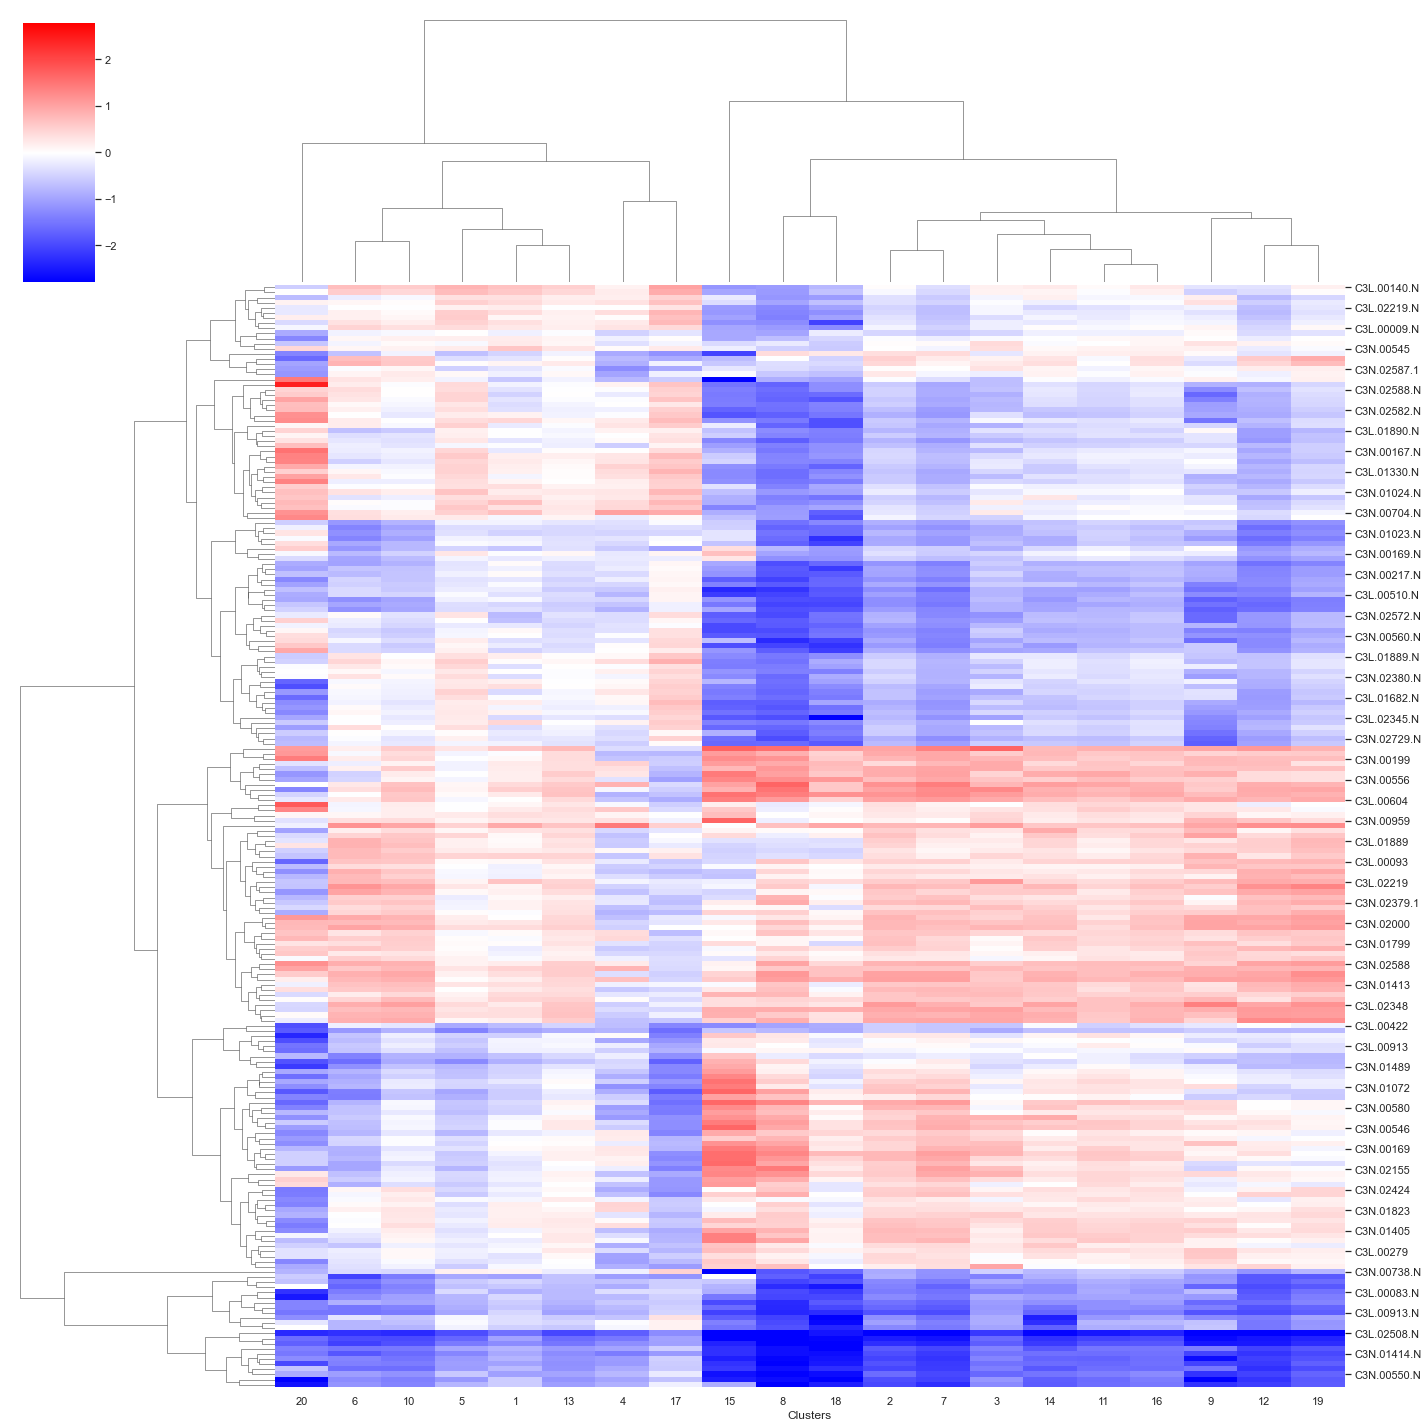

In [434]:
from msresist.figures.figure1 import plotClustergram
import seaborn as sns
plotClustergram(centers.T, "", lim=max(np.max(np.abs(centers.T)) * 0.2), figsize=(20, 20))
# plt.savefig("CPTAC_GMM.svg", bbox_inches='tight', format='svg', dpi=1200)

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(7,6))
# p1 = PLSRegression(n_components=2)
# plotR2YQ2Y(ax, p1, d, y_, 1, 10)

In [435]:
cf = pd.read_csv("Y_CPTAC.csv")
cf_ = cf.replace("Living", 0)
cf_ = cf_.replace("Deceased", 1)
cf_ = cf_.replace("No", 0)
cf_ = cf_.replace("Yes", 1)

In [436]:
IDict = pd.read_csv("IDs.csv", header=0)
IDict_ = dict(zip(IDict.iloc[:, 0], IDict.iloc[:, 1]))

In [437]:
ids = []
for i in range(cf.shape[0]):
    ids.append(IDict_[cf_.iloc[i, 0]])
cf_["Patient_ID"] = ids

In [438]:
for i in range(cf_.shape[0]):
    id_ = cf_.iloc[i, 0].split(".N")[0]
    cf_.loc[-1] = [id_, cf_.iloc[i, 1], cf_.iloc[i, 2]]
    cf_.index = cf_.index + 1
cf_.loc[-1] = ["C3N.02379.1", 0, 0]
cf_.index = cf_.index + 1
cf_ = cf_.sort_index()

In [439]:
for col in centers.columns:
    if col not in list(cf_["Patient_ID"]):
        print(col)

C3N.02587
C3N.02587.N


In [440]:
centers = centers.drop(["C3N.02587", "C3N.02587.N"], axis=1)

In [441]:
y = pd.read_csv("y.csv").set_index("Patient_ID")

In [442]:
centers = centers.reset_index().drop("Clusters", axis=1).T.reset_index().sort_values(by="index")
y = y.reset_index().sort_values(by="Patient_ID")

In [443]:
centers = centers.set_index("index")
y = y.set_index("Patient_ID")

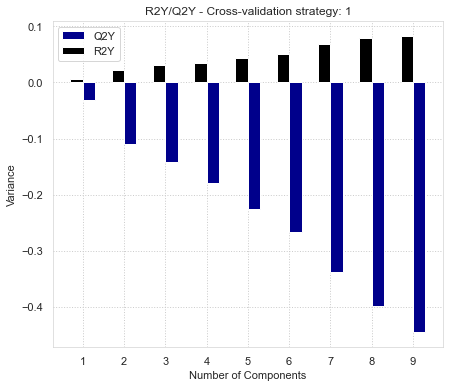

In [444]:
from msresist.figures.figure3 import plotR2YQ2Y
fig, ax = plt.subplots(1, 1, figsize=(7,6))
p1 = PLSRegression(n_components=2, scale=False)
plotR2YQ2Y(ax, p1, centers, y, 1, 10)

In [445]:
centers.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
index,,,,,,,,,,,,,,,,,,,,
C3L.00001,-0.039726,0.655264,0.513045,-0.814116,0.023266,0.440178,0.691025,0.508726,0.550952,0.566439,0.379203,0.681920,0.345985,0.605274,0.460801,0.524860,-0.724785,0.067674,0.878801,-0.906079
C3L.00001.N,-0.247407,-1.012755,-0.774158,-0.311622,-0.219107,-0.230963,-1.238536,-1.796049,-0.792116,-0.441022,-0.805449,-1.136831,-0.464842,-0.847568,-1.972315,-0.740227,-0.034711,-1.691445,-0.740365,-0.139812
C3L.00009,-0.058253,0.257538,-0.098824,-0.162742,0.140854,0.531460,0.258942,0.472409,0.563428,0.406633,0.309453,0.455361,0.180069,0.107358,-0.293276,0.254268,-0.351045,0.117468,0.605631,-0.046564
C3L.00009.N,0.244013,-0.112928,-0.192155,0.295853,0.385822,0.468506,-0.484020,-1.104762,0.115267,0.327303,-0.067571,-0.437207,0.187803,0.024280,-0.978127,0.029662,0.393186,-1.258832,0.084933,-0.094892
C3L.00080,0.193631,1.040358,0.573098,0.696043,0.042776,0.764922,1.044720,1.050970,1.005989,0.868341,0.779242,1.002149,0.455018,0.876557,0.585857,0.759650,-0.456817,0.872104,1.111415,0.182122


424/21759 peptides were not found in the proteome.
21335


/home/marcc/resistance-MS/msresist/motifs.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Gene'] = names
/home/marcc/resistance-MS/msresist/motifs.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Sequence'] = seqs


In [446]:
list(range(20))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [449]:
centers = centers.drop("C3N.00738.N")

In [450]:
centers = centers.reset_index()

In [451]:
from sklearn.decomposition import PCA
from msresist.figures.figure1 import pca_dfs

c=2
pp = PCA(n_components=c)
dScor_ = pp.fit_transform(centers.iloc[:, 1:])
dLoad_ = pp.components_
dScor_, dLoad_ = pca_dfs(dScor_, dLoad_, centers, c, ["index"], "Cluster")

In [452]:
dScor_.columns = ["PC1", "PC2", "Patient_ID"]

In [453]:
tumortype = []
for i in range(dScor_.shape[0]):
    if ".N" in dScor_["Patient_ID"][i]:
        tumortype.append("Normal")
    else:
        tumortype.append("Tumor")

In [454]:
dScor_["Type"] = tumortype

In [455]:
varExp = np.round(pp.explained_variance_ratio_, 2)

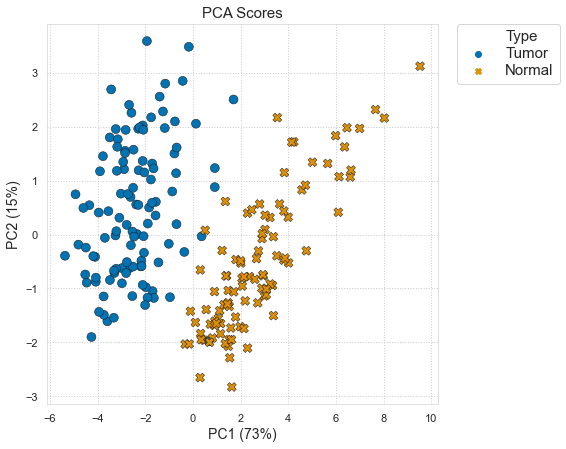

In [468]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.scatterplot(x="PC1", y="PC2", data=dScor_, hue="Type", style="Type", ax=ax, s=80, **{'linewidth':.5, 'edgecolor':"k"})
ax.set_title("PCA Scores", fontsize=15)
ax.set_xlabel("PC1 (" + str(int(varExp[0] * 100)) + "%)", fontsize=14)
ax.set_ylabel("PC2 (" + str(int(varExp[1] * 100)) + "%)", fontsize=14)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, labelspacing=0.2, fontsize=15);
plt.savefig("PCA_CPTAC_20cl_Scores.svg", bbox_inches='tight', format='svg', dpi=1200)

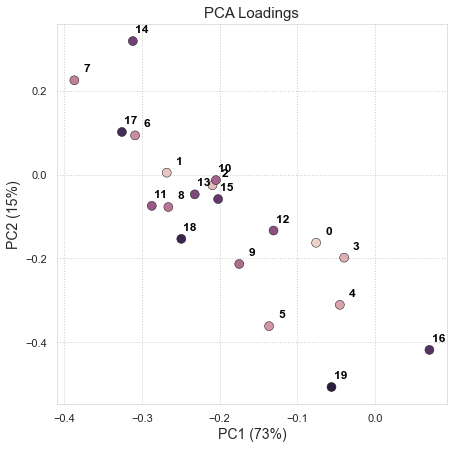

In [469]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.scatterplot(x="PC1", y="PC2", data=dLoad_, hue="Cluster", ax=ax, s=80, **{'linewidth':.5, 'edgecolor':"k"})
for line in range(0, dLoad_.shape[0]):
     ax.text(dLoad_.iloc[line, 0]+0.02, dLoad_.iloc[line, 1]+0.02, dLoad_["Cluster"][line], horizontalalignment='right', size='medium', color='black', weight='semibold')
ax.legend().remove()
ax.set_title("PCA Loadings", fontsize=15)
ax.set_xlabel("PC1 (" + str(int(varExp[0] * 100)) + "%)", fontsize=14)
ax.set_ylabel("PC2 (" + str(int(varExp[1] * 100)) + "%)", fontsize=14);
plt.savefig("PCA_CPTAC_20cl_Loadings.svg", bbox_inches='tight', format='svg', dpi=1200)